# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline

## Data Pre-Processing

Merge the yearly and quarterly data downloaded from lending club website. 

In [2]:
loanstats_input = ['2007_2011', '2012_2013', '2014', '2015', 
                   '2016Q1', '2016Q2', '2016Q3', '2016Q4', 
                   '2017Q1', '2017Q2', '2017Q3', '2017Q4', 
                   '2018Q1', '2018Q2', '2018Q3']

for i in loanstats_input: 
    if i == '2007_2011': 
        df_raw = pd.read_csv("data/LoanStats/LoanStats_securev1_%s.csv" % i, header=1)
        df_raw = df_raw[:-2]
    else: 
        temp = pd.read_csv("data/LoanStats/LoanStats_securev1_%s.csv" % i, header=1)
        temp = temp[:-2]
        df_raw = df_raw.append(temp)
        
df_raw = df_raw.reset_index(drop=True)

### Feature Selection
There are totally 151 columns in the raw dataset. In the initial feature selection stage, we applied several very rigorious selection criteria: 
- The full sample feature coverage should be larger than 60%, otherwise, there are two many missing values. 
    - Around 5% of the loans are joint applications in full sample, which means 95% of the feature columns regarding the second applicatant will be missing. Thus, all the columns regarding the second applicant are droped, for example FICO scores (sec_app_fico_range_low, sec_app_fico_range_high), earliest credit line at time (sec_app_earliest_cr_line), etc for the second applicant.
    - Some other columns have coverage less than 60% as well. For example, column number of months since the borrower's last delinquency (mths_since_last_major_derog) has only 25% coverage. For the missing data, it's impossible for us to know exactly the reason hehind it, either because of unavailability by nature or unwillingess of applicants providing the information. Thus, we decided to drop these types of columns as well.
- The features with look-ahead bias are droped. 
    - Column post charge off gross recovery (recoveries) will directly indicate the loan has been in charge-off status. However, as an investor, we want to predict if loan is going to end up as a good loan or bad loan at the initiation stage. The information of recoveries is not what we know about beforehand. Thus, we have to drop it from the predictors. 
    - There are some other columns have to be droped as well, for example late fees received to date (total_rec_late_fee), payments received to date for total amount funded, etc. All the information that is not known at the beginning of the application should not be included as predictors. 
- The redudant features are droped. 
    - Credit grades and credit sub grades contain the same information, but just in different granularity. We kept grades and droped sub grades. 
    - Zip codes and States also contain similar information, and we kept states as predictor, partly because there are too many zip codes.   
    - From fixed income formula, we can mathematically calculate the monthly installment amount given annual interest rate, term and loan amount. Thus, installment does not contain any new information, and thus is dropped.   

In [65]:
df = df_raw[["loan_amnt"
             , "term"
             , "int_rate"
             , "grade"
             , "emp_length"
             , "home_ownership"
             , "annual_inc"
             , "verification_status"
             , "issue_d"
             , "loan_status"
             , "purpose"
             , "addr_state"
             , "dti"
             , "delinq_2yrs"
             , "earliest_cr_line"
             , "fico_range_low"
             , "fico_range_high"
             , "inq_last_6mths"
             , "open_acc"
             , "pub_rec"
             , "revol_util"
             , "application_type"
             , "acc_now_delinq"
             , "tot_coll_amt"
             , "tot_cur_bal"]]

### Data Cleaning
- Drop rows that are all NA
- Change some columns of string types to numeric types 
- Special treatment for certain columns:
    - There are less than 0.01% missing data in variable revol_util, which is the percentage amount of credit the borrower is using relative to all available revolving credit. We treat these missing observations as bad data, and thus, droppred from the dataset. 

In [66]:
# Drop rows that are all NA
df.dropna(how='all', inplace=True)

# Change some columns of string types to numeric types
df['int_rate'] = df['int_rate'].apply(lambda x: float(x.strip().replace('%', '')))
df['term'] = df['term'].apply(lambda x: int(x.strip().replace('months', '')))

# Column revol_util
df['temp'] = df['revol_util'].apply(lambda x: 1 if isinstance(x, float) else 0)
df = df[df['temp']==0]
df.drop(['temp'], axis=1, inplace=True)
df['revol_util'] = df['revol_util'].apply(lambda x: float(x.strip().replace('%', '')))

## EDA

### Distribution of Loans

<h4> Summary: </h4>
<li> Lending Club business is doing well in term of the incremental <b>mean loan amount</b>. We can see that borrowers are relying more on the platform to finance over the years. </li>
<li> Majority of the <b>loan amount</b> is ranging from 5,000 to 20,000 USD. </li> 


In [67]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['year'] = df['issue_d'].apply(lambda x: int(x.year))

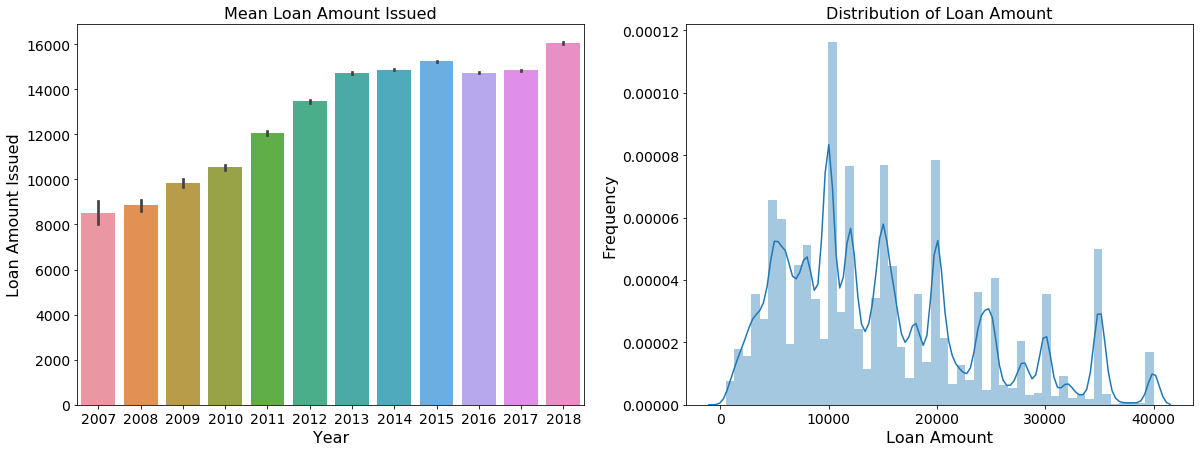

In [5]:
import warnings
warnings.filterwarnings('ignore')

f, ax = plt.subplots(1, 2, figsize=(20,7))

g1 = sns.barplot(df['year'], df['loan_amnt'], data=df, ax=ax[0])
g1.set_title('Mean Loan Amount Issued', fontsize=16)
g1.set_xlabel('Year', fontsize=16)
g1.set_ylabel('Loan Amount Issued', fontsize=16)
g1.tick_params(labelsize=14)

g2 = sns.distplot(df['loan_amnt'], ax=ax[1])
g2.set_xlabel('Loan Amount', fontsize=16)
g2.set_ylabel('Frequency', fontsize=16)
g2.set_title('Distribution of Loan Amount', fontsize=16)
g2.tick_params(labelsize=14)

### Good Loans vs Bad Loans

According the lending club website, here is the loan status definition: 
- <b>Current</b>: Loan is up to date on all outstanding payments. 
- <b>In Grace Period</b>: Loan is past due but within the 15-day grace period. 
- <b>Late (16-30)</b>: Loan has not been current for 16 to 30 days. 
- <b>Late (31-120)</b>: Loan has not been current for 31 to 120 days. 
- <b>Fully paid</b>: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
- <b>Default</b>: Loan has not been current for an extended period of time. 
- <b>Charged Off</b>: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. 

<h4> Summary: </h4>
<ul>
<li> Bad loans consist only <b>12.66%</b> of the total loans in full sample.</li>
<li> The number of bad loans typically tends to move together with the number of good loans over the years, however, that co-movement starts to diverge in recent three years. The reason is because almost of of the loans less than 3-years old are new loans, with most of them in the <b>status of current</b>. In order to reduce this <b>sample bias</b>, we will drop loans in recent years in feature engineering stage.</li>
</ul>

In [68]:
# Determining the loans that are bad from loan_status column
bad_loan = ["Charged Off", 
            "Default", 
            "Does not meet the credit policy. Status:Charged Off", 
            "In Grace Period", 
            "Late (16-30 days)", 
            "Late (31-120 days)"]

df['response'] = df['loan_status'].apply(lambda x: 'Bad Loan' if x in bad_loan else 'Good Loan')

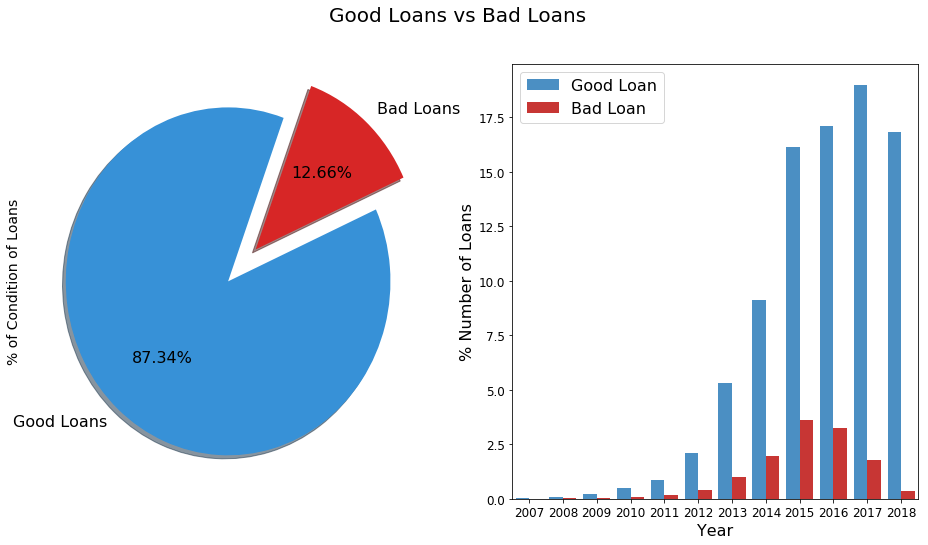

In [6]:
f, ax = plt.subplots(1, 2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels = "Good Loans", "Bad Loans"

plt.suptitle('Good Loans vs Bad Loans', fontsize=20)

df["response"].value_counts().plot.pie(
    explode=[0,0.25], 
    autopct='%1.2f%%',
    ax=ax[0], 
    shadow=True, 
    colors=colors, 
    labels=labels, 
    fontsize=16, 
    startangle=70)

ax[0].set_ylabel('% of Condition of Loans', fontsize=14)
ax[0].tick_params(labelsize=14)

palette = ["#3791D7", "#E01E1B"]

g = sns.barplot(x="year", 
                y="loan_amnt", 
                hue="response", 
                data=df, 
                palette=palette, 
                estimator=lambda x: len(x) / len(df) * 100)
ax[1].set_xlabel('Year', fontsize=16)
ax[1].set_ylabel('% Number of Loans', fontsize=16)
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=12)

### Loans by Grade 

<h4> Summary: </h4>
<ul>
<li> Most of the loan are with grades beween B and D. </li>
<li> <b>Generally, the higher the grade, the higher probabilities of bad loans.</b> </li>
</ul>

In [74]:
# Loans by grade
by_grade = df.groupby(['grade', 'response']).size().unstack()

# Normalized loans by grade 
by_grade_norm = by_grade.copy()
by_grade_norm['sum'] = by_grade_norm['Bad Loan'] + by_grade_norm['Good Loan']
by_grade_norm['Bad Loan'] = by_grade_norm.apply(lambda x: x['Bad Loan'] / x['sum'] * 100, axis=1)
by_grade_norm['Good Loan'] = by_grade_norm.apply(lambda x: x['Good Loan'] / x['sum'] * 100, axis=1)
by_grade_norm.drop(['sum'], inplace=True, axis=1)

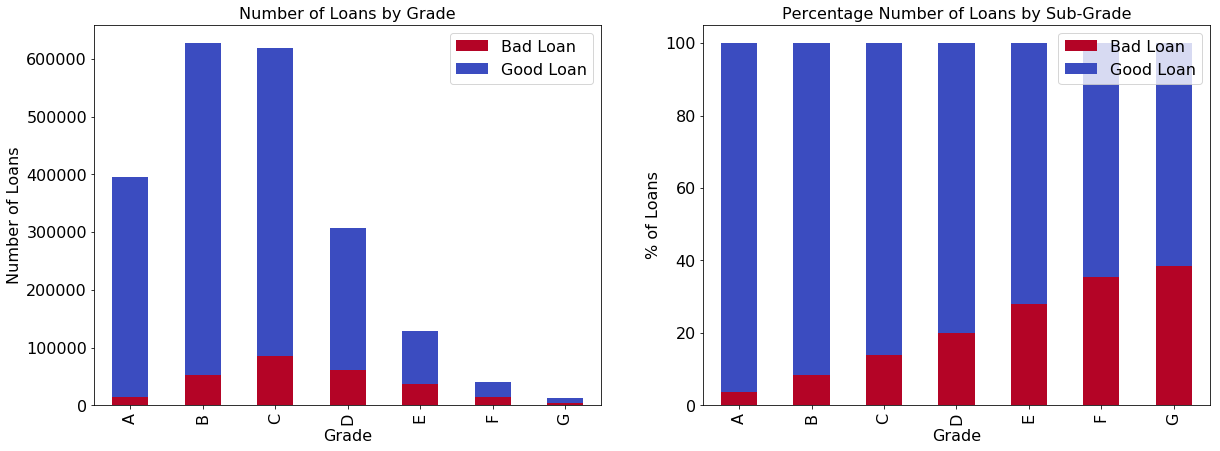

In [75]:
f, ax = plt.subplots(1, 2, figsize=(20,7))

cmap = plt.cm.coolwarm_r

by_grade.plot(kind='bar', stacked=True, colormap=cmap, ax=ax[0], grid=False)
ax[0].set_title('Number of Loans by Grade', fontsize=16)
ax[0].set_xlabel('Grade', fontsize=16)
ax[0].set_ylabel('Number of Loans', fontsize=16)
ax[0].tick_params(labelsize=16)
ax[0].legend(fontsize=16)

by_grade_norm.plot(kind='bar', stacked=True, ax=ax[1], colormap=cmap)
ax[1].set_title('Percentage Number of Loans by Sub-Grade', fontsize=16)
ax[1].set_xlabel('Grade', fontsize=16)
ax[1].set_ylabel('% of Loans', fontsize=16)
ax[1].tick_params(labelsize=16)
ax[1].legend(fontsize=16)
plt.show()

### Loans by Purpose 

<h4> Findings Summary: </h4>
<ul>
<li> <b>Debt consolidation</b> is the biggest purpose for the loans from the borrowers. </li>
<li> Even though <b>education</b> as a purpose of loans has the smallest percentage, the default rate is the <b>highest</b> among all purposes, followed by <b>small business</b>.</li>
</ul>

In [9]:
# Loans by purpose
by_purpose = df.groupby(['response', 'purpose']).size().unstack().T
by_purpose['sum'] = by_purpose['Bad Loan'] + by_purpose['Good Loan']
by_purpose.sort_values(['sum'], inplace=True)
by_purpose.drop(['sum'], axis=1, inplace=True)

# Normalized loans by purpose
by_purpose_norm = df.groupby(['response', 'purpose']).size().unstack().apply(lambda x: x/x.sum() * 100).T
by_purpose_norm.sort_values(['Bad Loan'], inplace=True)

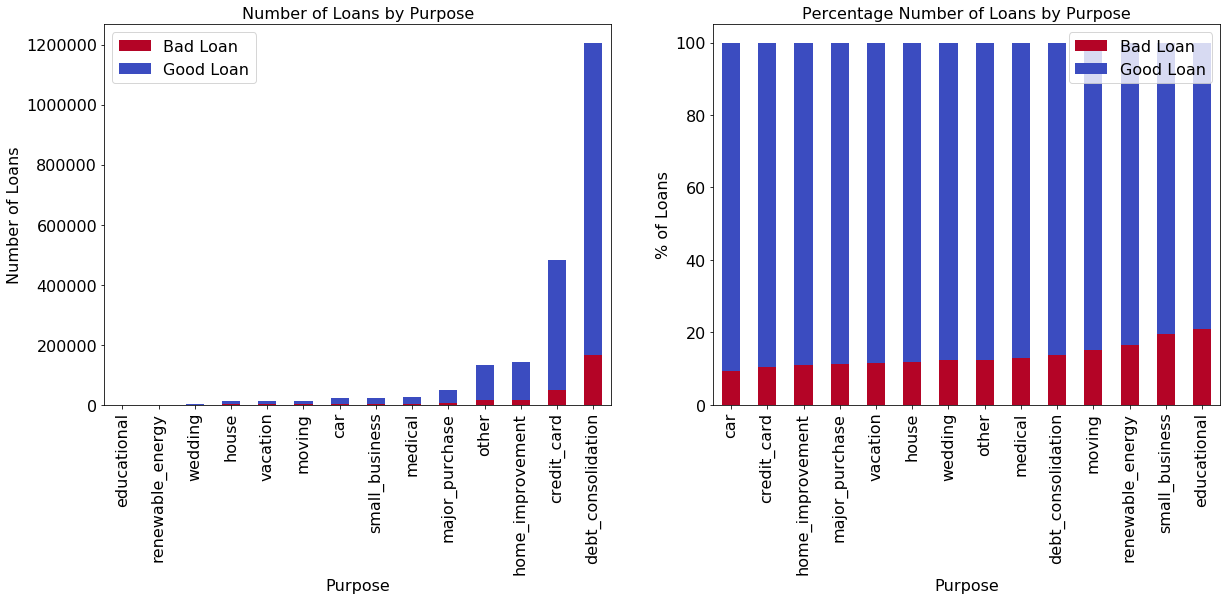

In [10]:
f, ax = plt.subplots(1, 2, figsize=(20,7))

cmap = plt.cm.coolwarm_r

by_purpose.plot(kind='bar', stacked=True, colormap=cmap, ax=ax[0], grid=False)
ax[0].set_title('Number of Loans by Purpose', fontsize=16)
ax[0].set_xlabel('Purpose', fontsize=16)
ax[0].set_ylabel('Number of Loans', fontsize=16)
ax[0].tick_params(labelsize=16)
ax[0].legend(fontsize=16)

by_purpose_norm.plot(kind='bar', stacked=True, ax=ax[1], colormap=cmap)
ax[1].set_title('Percentage Number of Loans by Purpose', fontsize=16)
ax[1].set_xlabel('Purpose', fontsize=16)
ax[1].set_ylabel('% of Loans', fontsize=16)
ax[1].tick_params(labelsize=16)
ax[1].legend(fontsize=16)
plt.show()

### Loans by State 

<h4> Summary: </h4>
<ul>
<li> The loan defulat rates are very marginally different among US states, and could add more noise than information.</li>
<li> IOWA has the highest default rate among all states, but further investigation shows that there are only 14 loans in Iowa in full history, so we'd better not think too much into it. </li>
</ul>

In [11]:
by_state = df.groupby(['response', 'addr_state']).size().unstack().T
by_state['bad_loan_ptg'] = by_state.apply(lambda x: x['Bad Loan'] / (x['Bad Loan'] + x['Good Loan']), axis=1)
by_state.reset_index(inplace=True)

In [12]:
for col in by_state.columns:
    by_state[col] = by_state[col].astype(str)
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

by_state['text'] = by_state['addr_state'] 

data = [dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = by_state['addr_state'],
        z = by_state['bad_loan_ptg'], 
        locationmode = 'USA-states',
        text = by_state['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]


layout = dict(
    title = 'Default Rates by States',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

### Loans by Debt-to-Income Ratio 

<h4> Summary: </h4>
<ul>
<li> <b>Bad loans have higher debt-to-income ratios. </b></li>
<li> By visual inspection, bad loans have DTI ratio around 17, while good loans around 20. </li>
</ul>

In [13]:
# Loans with DTI 
dti_good = list((df.dropna(subset=['dti']))[df['response']=='Good Loan']['dti'])
dti_bad = list((df.dropna(subset=['dti']))[df['response']=='Bad Loan']['dti'])

dti_good_low, dti_good_high = np.percentile(dti_good, 0), np.percentile(dti_good, 99)
dti_bad_low, dti_bad_high = np.percentile(dti_bad, 0), np.percentile(dti_bad, 99)

dti_good_trim = [x for x in dti_good if x > dti_good_low and x < dti_good_high]
dti_bad_trim = [x for x in dti_bad if x > dti_bad_low and x < dti_bad_high]

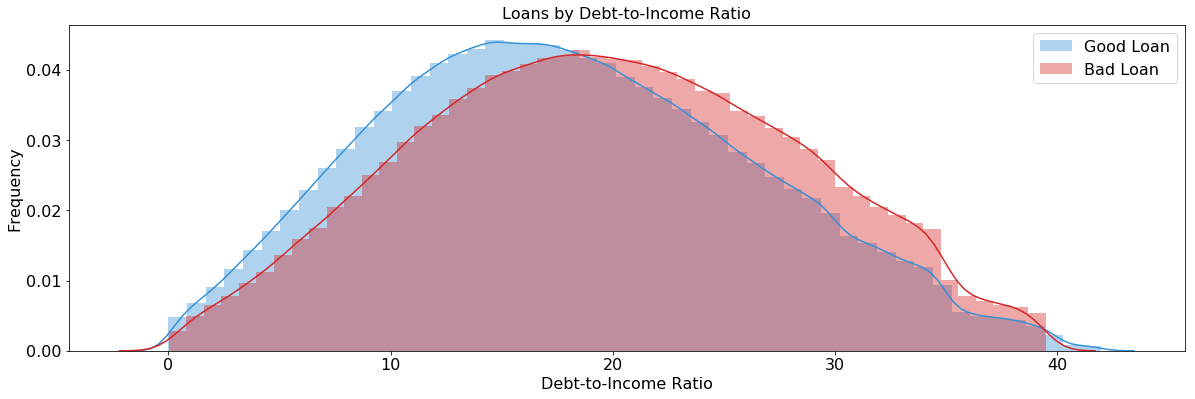

In [14]:
f, ax = plt.subplots(figsize=(20,6))

colors = ["#3791D7", "#D72626"]

sns.distplot(dti_good_trim, ax=ax, color=colors[0], label='Good Loan')
sns.distplot(dti_bad_trim, ax=ax, color=colors[1], label='Bad Loan')
plt.title("Loans by Debt-to-Income Ratio", fontsize=16)
plt.xlabel('Debt-to-Income Ratio', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

### Loans by FICO score 

<h4> Summary: </h4>
<ul>
<li> The distributions of FICO scores of good and bad loans are similar overall, with majority of scores between 670 to 720. However, <b>good loans have higher FICO scores on the right tail, above 740. </b> This makes economic sense, because good loan applicants with high FICO scores will tend to pay the monthly installment on time.</li>
</ul>

In [72]:
# Loans with FICO 
df['fico'] = (df['fico_range_low'] + df['fico_range_high']) / 2

In [50]:
fico_good = list(df[df['response']=='Good Loan']['fico'])
fico_bad = list(df[df['response']=='Bad Loan']['fico'])

fico_good_low, fico_good_high = np.percentile(fico_good, 0.5), np.percentile(fico_good, 99)
fico_bad_low, fico_bad_high = np.percentile(fico_bad, 0.5), np.percentile(fico_bad, 99)

fico_good_trim = [x for x in fico_good if x > fico_good_low and x < fico_good_high]
fico_bad_trim = [x for x in fico_bad if x > fico_bad_low and x < fico_bad_high]

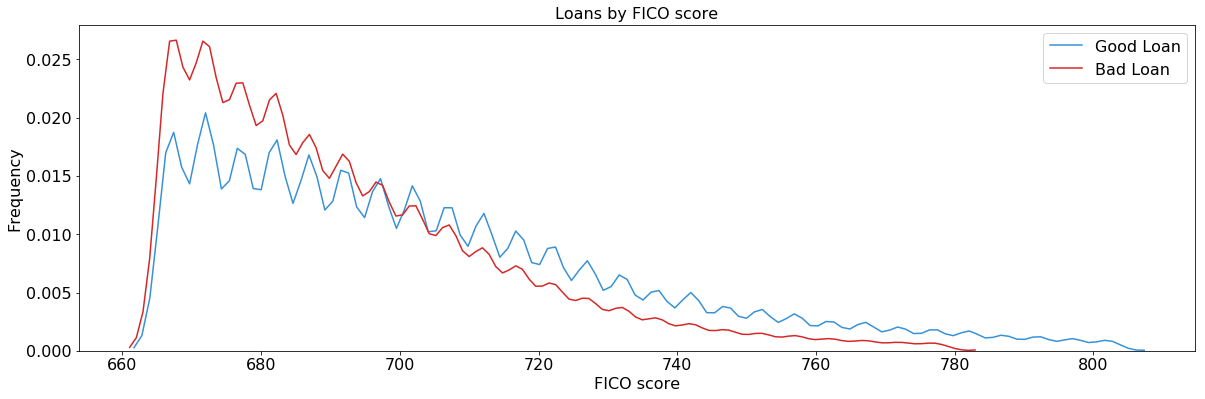

In [51]:
f, ax = plt.subplots(figsize=(20,6))

colors = ["#3791D7", "#D72626"]

sns.distplot(fico_good_trim, hist=False, bins=50, ax=ax, color=colors[0], label='Good Loan')
sns.distplot(fico_bad_trim, hist=False, bins=50, ax=ax, color=colors[1], label='Bad Loan')
plt.title("Loans by FICO score", fontsize=16)
plt.xlabel('FICO score', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

In [73]:
# Output dataset
df.to_csv("data/output_eda.csv", index=False)